### Pipelines that needs to be performed:
- You need to perform the following eight major tasks to complete the assignment:

1. Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

### Problem Statement
- You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

- You will be doing topic modelling on the .json data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

- Credit card / Prepaid card

- Bank account services

- Theft/Dispute reporting

- Mortgages/loans

- Others

- With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## 1. Data Loading

In [1]:
## importing librraries
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn import decomposition
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/abhinavjoshi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhinavjoshi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/abhinavjoshi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Loading the JSON file
- The data set is in the .json format

In [2]:
## opening the JSON file
f = open('/Users/abhinavjoshi/Downloads/complaints-2021-05-14_08_16.json')

In [4]:
## converting the file to dataframe
data = json.load(f)
df = pd.json_normalize(data)
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
## checking shape
df.shape

(78313, 22)

- The data set contains 78,313 customer complaints with 22 features.

In [6]:
## let's check the feature names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
## renaming the features
df.rename(columns ={'_index': 'index', '_type': 'type', '_id': 'id', '_score': 'score', '_source.tags': 'source_tags', 
                    '_source.zip_code': 'source_zip_code', '_source.complaint_id': 'source_complaint_id',
                    '_source.complaint_id': 'source_complaint_id', '_source.issue': 'source_issue',
                    '_source.date_received': 'source_date_received', '_source.state': 'source_state',
                    '_source.consumer_disputed': 'source_consumer_disputed', '_source.product': 'source_product',
                    '_source.company_response': 'source_company_response', '_source.company': 'source_company',
                    '_source.submitted_via': 'source_submitted_via', '_source.date_sent_to_company': 'source_date_sent_to_company',
                    '_source.company_public_response': 'source_company_public_response', '_source.sub_product': 'source_sub_product',
                    '_source.timely': 'source_timely', '_source.complaint_what_happened': 'source_complaint_what_happened',
                    '_source.sub_issue': 'source_sub_issue', '_source.consumer_consent_provided': 'source_consumer_consent_provided'}, inplace = True)

In [8]:
## let's check the feature names again
df.columns

Index(['index', 'type', 'id', 'score', 'source_tags', 'source_zip_code',
       'source_complaint_id', 'source_issue', 'source_date_received',
       'source_state', 'source_consumer_disputed', 'source_product',
       'source_company_response', 'source_company', 'source_submitted_via',
       'source_date_sent_to_company', 'source_company_public_response',
       'source_sub_product', 'source_timely', 'source_complaint_what_happened',
       'source_sub_issue', 'source_consumer_consent_provided'],
      dtype='object')

In [9]:
## let's see the value counts
df.value_counts

<bound method DataFrame.value_counts of                      index       type       id  score    source_tags  \
0      complaint-public-v2  complaint  3211475    0.0           None   
1      complaint-public-v2  complaint  3229299    0.0  Servicemember   
2      complaint-public-v2  complaint  3199379    0.0           None   
3      complaint-public-v2  complaint  2673060    0.0           None   
4      complaint-public-v2  complaint  3203545    0.0           None   
...                    ...        ...      ...    ...            ...   
78308  complaint-public-v2  complaint  3105617    0.0           None   
78309  complaint-public-v2  complaint  3091984    0.0           None   
78310  complaint-public-v2  complaint  3133355    0.0           None   
78311  complaint-public-v2  complaint  3110963    0.0           None   
78312  complaint-public-v2  complaint  2001189    0.0           None   

      source_zip_code source_complaint_id  \
0               90301             3211475   
1    

In [10]:
## looking for unique values
df.nunique()

index                                   1
type                                    1
id                                  78313
score                                   1
source_tags                             3
source_zip_code                      9442
source_complaint_id                 78313
source_issue                          154
source_date_received                 3444
source_state                           62
source_consumer_disputed                3
source_product                         17
source_company_response                 8
source_company                          1
source_submitted_via                    6
source_date_sent_to_company          3309
source_company_public_response          3
source_sub_product                     72
source_timely                           2
source_complaint_what_happened      20931
source_sub_issue                      205
source_consumer_consent_provided        5
dtype: int64

In [11]:
## checking the number of null values
df.isnull().sum()

index                                   0
type                                    0
id                                      0
score                                   0
source_tags                         67413
source_zip_code                      6757
source_complaint_id                     0
source_issue                            0
source_date_received                    0
source_state                         1991
source_consumer_disputed                0
source_product                          0
source_company_response                 0
source_company                          0
source_submitted_via                    0
source_date_sent_to_company             0
source_company_public_response      78309
source_sub_product                  10571
source_timely                           0
source_complaint_what_happened          0
source_sub_issue                    46297
source_consumer_consent_provided     1008
dtype: int64

In [14]:
df['source_complaint_what_happened'].value_counts()

In [15]:
#Assign nan in place of blanks in the complaints column
df[df['source_complaint_what_happened']== ''] = np.nan 

In [16]:
## checking for NAN
df['source_complaint_what_happened']

0                                                      NaN
1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                      NaN
4                                                      NaN
                               ...                        
78308                                                  NaN
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: source_complaint_what_happened, Length: 78313, dtype: object

In [17]:
#Remove all rows where complaints column is nan
df = df[df['source_complaint_what_happened'].notnull()]

In [18]:
## shape
df.shape

(21072, 22)

In [19]:
## checking nulll values
df.isnull().sum()

index                                   0
type                                    0
id                                      0
score                                   0
source_tags                         17256
source_zip_code                      4645
source_complaint_id                     0
source_issue                            0
source_date_received                    0
source_state                          143
source_consumer_disputed                0
source_product                          0
source_company_response                 0
source_company                          0
source_submitted_via                    0
source_date_sent_to_company             0
source_company_public_response      21070
source_sub_product                   2109
source_timely                           0
source_complaint_what_happened          0
source_sub_issue                     8176
source_consumer_consent_provided        0
dtype: int64

## Prepare the text for topic modeling
Once you have removed all the blank complaints, you need to:

- Make the text lowercase
- Remove text in square brackets
- Remove punctuation
- Remove words containing numbers

- Once you have done these cleaning operations you need to perform the following:

#### Lemmatize the texts
- Use POS tags to get relevant words from the texts.

In [20]:
# Function to clean the text and remove all the unnecessary elements.
def clean_text(text):
  text = text.lower()
  pattern = re.compile('[\(\[].*?[\)\]]')
  text = re.sub(pattern, '', text)
  pattern = re.compile('[^\w\s]')
  text = re.sub(pattern, '', text)
  pattern = re.compile('[0-9]')
  text = re.sub(pattern, '', text)
  return text

In [21]:
## importing libraries
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/abhinavjoshi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhinavjoshi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/abhinavjoshi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
# Function to Lemmatize the texts
def lemmatizer(text):      
    text = clean_text(text)  
    sent = [wordnet_lemmatizer.lemmatize(word) for word in word_tokenize(text) if not word in set(stopwords.words('english'))]
    return " ".join(sent)

In [23]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame()
df_clean['complaints'] = df['source_complaint_what_happened'].apply(lambda x: clean_text(x))
df_clean['lemmatized_complaints'] = df['source_complaint_what_happened'].apply(lambda x: lemmatizer(x))

In [24]:
## checking df_clean
df_clean.head()

,complaints,lemmatized_complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...


In [25]:
# function to extract the POS tags 
def pos_tag(text):
  doc = nlp(text)
  result = []
  for token in doc:
    if token.pos_ == 'NOUN':
      output = result.append(token.text)
      
  return ' '.join(result)


In [26]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean['complaint_POS_removed'] = df_clean['complaints'].apply(lambda x: pos_tag(x))

In [27]:
## checking df_clean
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop debt verification statement ...
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,xxxx card agent anniversary date agent informa...
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,application identity consent services credit i...
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx xxxx xxxx ticket offer ticket rewards car...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...


### Exploratory data analysis to get familiar with the data.
- Write the code in this task to perform the following:

- Visualise the data according to the 'Complaint' character length
- Using a word cloud find the top 40 words by frequency among all the articles after processing the text
- Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘

In [28]:
## importing libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,6))

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

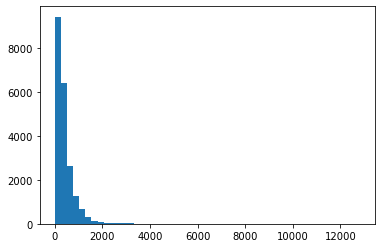

In [29]:
## plotting 
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 50)
plt.show()

In [30]:
## installing wordcloud
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


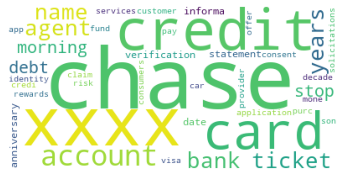

In [31]:
## Find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
stoplist = set(stopwords.words("english"))
wordcloud = WordCloud(stopwords=stoplist,max_words=40, background_color='white').generate(str(df_clean.complaint_POS_removed))                       
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [32]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text


In [33]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean
def get_top_n_unigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
    

In [35]:
#Print the top 10 words in the unigram frequency
df_unigram = pd.DataFrame(common_words_uni, columns = ['unigram' , 'count'])
df_unigram.head(10)

,unigram,count
0,xxxx,140012
1,chase,54073
2,account,40565
3,credit,31646
4,card,25806
5,bank,17851
6,xxxxxxxx,15343
7,payment,13754
8,money,11806
9,time,11692


In [36]:
## bigram
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [38]:
#Print the top 10 words in the bigram frequency
df_bigram = pd.DataFrame(common_words_bi, columns = ['bigram' , 'count'])
df_bigram.head(10)

,bigram,count
0,xxxx xxxx,64600
1,credit card,10652
2,xxxx chase,4317
3,account xxxx,3288
4,credit report,3197
5,chase credit,3009
6,customer service,2984
7,chase xxxx,2845
8,chase account,2776
9,xxxx account,2576


In [39]:
## trigram
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [41]:
#Print the top 10 words in the trigram frequency
df_trigram = pd.DataFrame(common_words_tri, columns = ['trigram' , 'count'])
df_trigram.head(10)

,trigram,count
0,xxxx xxxx xxxx,34673
1,xxxx xxxx chase,1726
2,chase credit card,1721
3,account xxxx xxxx,1172
4,xxxxxxxx xxxx xxxx,1040
5,chase xxxx xxxx,1018
6,xxxx xxxx account,995
7,xxxx credit card,859
8,credit card company,783
9,credit card account,762


####  The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis 

In [42]:
## removing masked text
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [43]:
## checking df_clean
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,application identity consent services credit i...,application identity consent services credit i...
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx xxxx xxxx ticket offer ticket rewards car...,ticket offer ticket rewards card informatio...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitations credi...,chase card customer decade solicitations credi...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,xxxx xxxx visa credit card provider claim purc...,visa credit card provider claim purchase pro...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumers chase bank app chase years ...,pay risk consumers chase bank app chase years ...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit yrs chase credit cards chase freedom pr...,credit yrs chase credit cards chase freedom pr...


- Masks removed

In [45]:
## saving df_clean as .csv file
df_clean.to_csv('df_clean.csv', index=False)
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,application identity consent services credit i...,application identity consent services credit i...
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx xxxx xxxx ticket offer ticket rewards car...,ticket offer ticket rewards card informatio...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [46]:
#Write your code here to initialise the TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
tfidf = vectorizer.fit_transform(df_clean.Complaint_clean)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [47]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = vectorizer.fit_transform(df_clean['complaint_POS_removed'])

In [48]:
pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names())

,aa,aaaratings,aarp,abandonment,abatement,abd,abide,abilities,ability,abs,...,youxxxx,youxxxxxxxx,yr,yrs,zeros,zip,zipcode,zombie,zone,zones
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.146716,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [49]:
## importing libraries
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [50]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5
#keep the random_state =40
nmf_model = NMF(n_components=num_topics,random_state = 40)
W = nmf_model.fit_transform(dtm)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix

In [51]:
## let's see how many topics are there 
len(vectorizer.get_feature_names())

7830

In [52]:
#Print the Top15 words for each of the topics
# Top 15 words per topic

words = np.array(vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,xxxx,number,bank,chase,xxxxxxxx,money,letter,email,information,phone,complaint,debt,case,address,transaction
Topic 2,card,chase,charges,charge,credit,fraud,fee,dispute,xxxxxxxx,balance,merchant,company,service,customer,statement
Topic 3,account,bank,check,money,chase,funds,checking,branch,deposit,accounts,days,business,fees,balance,checks
Topic 4,payment,loan,mortgage,payments,chase,modification,home,xxxxxxxx,time,month,years,rate,property,foreclosure,balance
Topic 5,credit,report,inquiry,inquiries,card,score,cards,accounts,account,debt,reporting,information,bureaus,limit,reports


In [53]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([0, 0, 4, ..., 1, 3, 3])

In [54]:
#Assign the best topic to each of the complaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1)
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,0
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,0
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,application identity consent services credit i...,application identity consent services credit i...,4
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx xxxx xxxx ticket offer ticket rewards car...,ticket offer ticket rewards card informatio...,4
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,2


In [60]:
#Print the first 5 Complaint for each of the Topics
## naming dataframe as df_clean_2 to conduct experiments
## setting display options
pd.set_option('display.max_colwidth',None)
df_clean_2=df_clean.groupby('Topic').head()
df_clean_2.sort_values('Topic')

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help,morning name stop debt verification statement bank debt mail month debt right information consumer chase xxxx xxxx xxxx xxxx thanks advance help,morning name stop debt verification statement bank debt mail month debt right information consumer chase thanks advance help,0
2,i upgraded my xxxx xxxx card in xxxx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgraded xxxx xxxx card xxxx told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account xxxx changed anniversary date xxxxxxxx xxxxxxxx without consent xxxx recording agent misled,xxxx card agent anniversary date agent information order account anniversary date consent xxxx recording agent,card agent anniversary date agent information order account anniversary date consent recording agent,0
73,i have wired through one of chase branches in xxxx xxxx the exact reinstatement amount of to jpmorgan chase bank in order to removewithdraw their wrongful foreclosure proceedings on my residential property\n\nhowever the chase executive ms xxxx xxxx and its trustee xxxx xxxx xxxx xxxx are not honoring even their own rules and regulations she wants the total payoff of now in order to remove their wrongful foreclosure proceedings with sales date of xxxx at xxxx xxxx on my family resident\n\nshe knows i can not prepare xxxx in such a short time thats why i asked for minimum reinstatement amount to avoid foreclosure without resorting to chapter xxxx bankruptcy filing\n\ni appreciate you assistant in bringing jpmorgan chase and its foreclosure trustee xxxx xxxx xxxx xxxx quality to their senses and stop harassing my family with their fraudulent default claim as explained in my previous complaint about them on xxxxxxxx\n\nmy previous complaint id is xxxx submitted xxxx product mortgage issue wrongful foreclosure\n\nthank you xxxx xxxx tell xxxx email xxxx xxxx,wired one chase branch xxxx xxxx exact reinstatement amount jpmorgan chase bank order removewithdraw wrongful foreclosure proceeding residential property however chase executive m xxxx xxxx trustee xxxx xxxx xxxx xxxx honoring even rule regulation want total payoff order remove wrongful foreclosure proceeding sale date xxxx xxxx xxxx family resident know prepare xxxx short time thats asked minimum reinstatement amount avoid foreclosure without resorting chapter xxxx bankruptcy filing appreciate assistant bringing jpmorgan chase foreclosure trustee xxxx xxxx xxxx xxxx quality sens stop harassing family fraudulent default claim explained previous complaint xxxxxxxx previous complaint id xxxx submitted xxxx product mortgage issue wrongful foreclosure thank xxxx xxxx tell xxxx email xxxx xxxx,chase branches xxxx xxxx reinstatement amount order foreclosure proceedings property executive trustee xxxx xxxx xxxx xxxx rules regulations payoff order foreclosure proceedings sales dat

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [61]:
## let's take a look at the complaints
df_clean_2.sort_values('Topic')

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help,morning name stop debt verification statement bank debt mail month debt right information consumer chase xxxx xxxx xxxx xxxx thanks advance help,morning name stop debt verification statement bank debt mail month debt right information consumer chase thanks advance help,0
2,i upgraded my xxxx xxxx card in xxxx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgraded xxxx xxxx card xxxx told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account xxxx changed anniversary date xxxxxxxx xxxxxxxx without consent xxxx recording agent misled,xxxx card agent anniversary date agent information order account anniversary date consent xxxx recording agent,card agent anniversary date agent information order account anniversary date consent recording agent,0
73,i have wired through one of chase branches in xxxx xxxx the exact reinstatement amount of to jpmorgan chase bank in order to removewithdraw their wrongful foreclosure proceedings on my residential property\n\nhowever the chase executive ms xxxx xxxx and its trustee xxxx xxxx xxxx xxxx are not honoring even their own rules and regulations she wants the total payoff of now in order to remove their wrongful foreclosure proceedings with sales date of xxxx at xxxx xxxx on my family resident\n\nshe knows i can not prepare xxxx in such a short time thats why i asked for minimum reinstatement amount to avoid foreclosure without resorting to chapter xxxx bankruptcy filing\n\ni appreciate you assistant in bringing jpmorgan chase and its foreclosure trustee xxxx xxxx xxxx xxxx quality to their senses and stop harassing my family with their fraudulent default claim as explained in my previous complaint about them on xxxxxxxx\n\nmy previous complaint id is xxxx submitted xxxx product mortgage issue wrongful foreclosure\n\nthank you xxxx xxxx tell xxxx email xxxx xxxx,wired one chase branch xxxx xxxx exact reinstatement amount jpmorgan chase bank order removewithdraw wrongful foreclosure proceeding residential property however chase executive m xxxx xxxx trustee xxxx xxxx xxxx xxxx honoring even rule regulation want total payoff order remove wrongful foreclosure proceeding sale date xxxx xxxx xxxx family resident know prepare xxxx short time thats asked minimum reinstatement amount avoid foreclosure without resorting chapter xxxx bankruptcy filing appreciate assistant bringing jpmorgan chase foreclosure trustee xxxx xxxx xxxx xxxx quality sens stop harassing family fraudulent default claim explained previous complaint xxxxxxxx previous complaint id xxxx submitted xxxx product mortgage issue wrongful foreclosure thank xxxx xxxx tell xxxx email xxxx xxxx,chase branches xxxx xxxx reinstatement amount order foreclosure proceedings property executive trustee xxxx xxxx xxxx xxxx rules regulations payoff order foreclosure proceedings sales dat

In [64]:
#Create the dictionary again of Topic names and Topics

Topic_names_1 = { 2:'Bank Account services',
                 1:'Credit card or prepaid card',
                4:'Theft/Dispute Reporting',
                3:'Mortgage/Loan',
                0:'Others'}
#Replace Topics with Topic Names
df_clean_2['Topic'].replace(to_replace=Topic_names_1,inplace=True)

/Users/abhinavjoshi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [81]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
b = df_clean[['Complaint_clean','Topic']]
b.head()

,Complaint_clean,Topic
1,morning name stop debt verification statement bank debt mail month debt right information consumer chase thanks advance help,0
2,card agent anniversary date agent information order account anniversary date consent recording agent,0
10,application identity consent services credit identity applicant,4
11,ticket offer ticket rewards card information offer minute screen decision chase bank minutes notification screen representative application information offer credit offer account statement ticket account application representative mins application request application representative chase fact credit account name credit report chase information credit report application error,4
14,son chase account fund chase bank account money son check money chase bank money son times check owner country time date number claim number chase,2


In [82]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= b

In [83]:
training_data.head()

,Complaint_clean,Topic
1,morning name stop debt verification statement bank debt mail month debt right information consumer chase thanks advance help,0
2,card agent anniversary date agent information order account anniversary date consent recording agent,0
10,application identity consent services credit identity applicant,4
11,ticket offer ticket rewards card information offer minute screen decision chase bank minutes notification screen representative application information offer credit offer account statement ticket account application representative mins application request application representative chase fact credit account name credit report chase information credit report application error,4
14,son chase account fund chase bank account money son check money chase bank money son times check owner country time date number claim number chase,2


In [84]:
## checking shape
training_data.shape

(21072, 2)

#### Apply the supervised models on the training data created. In this process, you have to do the following:
- Create the vector counts using Count Vectoriser
- Transform the word vecotr to tf-idf
- Create the train & test data using the train_test_split on the tf-idf & topics

In [205]:
## Create the vector counts using Count Vectoriser
## instantiating CountVectorizer() object
count_vect = CountVectorizer()

In [87]:
## fitting into CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data['Complaint_clean'])

In [89]:
## checking X_train_counts
X_train_counts

<21072x17135 sparse matrix of type '<class 'numpy.int64'>'
	with 613407 stored elements in Compressed Sparse Row format>

In [93]:
## imorting libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [94]:
## instantiating TfidfTransformer() object
tfidf_transformer = TfidfTransformer()

In [95]:
## fitting into TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [96]:
X_train_tfidf

<21072x17135 sparse matrix of type '<class 'numpy.float64'>'
	with 613407 stored elements in Compressed Sparse Row format>

#### Creating  the train & test data using the train_test_split on the tf-idf & topics

In [97]:
## importing libraries
from sklearn.model_selection import train_test_split

In [98]:
## train-test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

## Decision Tree Classifier
- Vanilla Decision Tree Classifier

In [105]:
## importing libraries
from sklearn.tree import DecisionTreeClassifier
## instantiating object of DecisionTreeClassifier class
dt = DecisionTreeClassifier()
## fitting into the tree
dt.fit(X_train,y_train)
## making predictions
y_train_pred = dt.predict(X_train)
y_test_pred  = dt.predict(X_test)

In [204]:
## importing libraries
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
## confusion matrix
print('Train Confusion Matrix')
print(confusion_matrix(y_train,y_train_pred))
print('*'*100)
print('Test Confusion Matrix')
print(confusion_matrix(y_test,y_test_pred))

Train Confusion Matrix
[[3259    2    1    0    3]
 [   0 3432    0    0    0]
 [   0    0 3949    0    0]
 [   4    0    0 2940    0]
 [   2    0    0    0 2212]]
****************************************************************************************************
Test Confusion Matrix
[[378 201 228 176  92]
 [201 841  48  30  47]
 [235  59 975  29  25]
 [148  24  36 694  31]
 [ 82  66  19  27 576]]


In [117]:
## classification report
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.36      0.35      0.36      1075
           1       0.71      0.72      0.71      1167
           2       0.75      0.74      0.74      1323
           3       0.73      0.74      0.73       933
           4       0.75      0.75      0.75       770

    accuracy                           0.66      5268
   macro avg       0.66      0.66      0.66      5268
weighted avg       0.66      0.66      0.66      5268



In [109]:
## accuracy
print('The accuracy of Train Set =',accuracy_score(y_train,y_train_pred))
print('The accuracy of Test Set =',accuracy_score(y_test,y_test_pred))

The accuracy of Train Set = 0.9992406985573272
The accuracy of Test Set = 0.6575550493545937


In [120]:
## precision,recall on test
from sklearn.metrics import recall_score,precision_score
print(recall_score(y_train,y_train_pred,average='weighted'))
print(precision_score(y_test,y_test_pred,average='weighted'))

0.9992406985573272
0.6555665763896672


- Accuracy and precision-recall scores point to over-fitting

#### Let's try hyperparameter tuning

In [171]:
## creating the dictionary of the parameters
params = {
    'max_depth':[2,3,5,10,20],
    'min_samples_leaf':[5,10,20,50,100],
    'criterion':['gini','entropy']
}

In [174]:
## importing GridSearchCV 
from sklearn.model_selection import GridSearchCV 

In [175]:
## making GridSeachCV
grid_search = GridSearchCV(estimator=dt ,param_grid=params,
                          cv=4,scoring='accuracy',n_jobs=-1,verbose=1)

In [176]:
## fitting into grid search
%time
grid_search.fit(X_train,y_train)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.01 µs
Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   19.2s finished


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [177]:
## getting the best model based on best estimator 
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=20, min_samples_leaf=20)

In [178]:
## evaluating the model dt_best as per the best estimator 
dt_best = grid_search.best_estimator_

In [180]:
## accuracy
print('The accuracy of Train Set =',accuracy_score(y_train,dt_best.predict(X_train)))
print('The accuracy of Test Set =',accuracy_score(y_test,dt_best.predict(X_test)))

The accuracy of Train Set = 0.7533535813718046
The accuracy of Test Set = 0.6858390280941534


- Overfitting handled
- Further hyperparameter tuning could yield better results

In [209]:
## classification report
print(classification_report(y_test,dt_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.40      0.35      0.37      1075
           1       0.71      0.76      0.73      1167
           2       0.77      0.80      0.78      1323
           3       0.73      0.77      0.75       933
           4       0.78      0.75      0.77       770

    accuracy                           0.69      5268
   macro avg       0.68      0.69      0.68      5268
weighted avg       0.68      0.69      0.68      5268



## RANDOM FOREST
- Vanilla Random Forest Classifier

In [121]:
## importing libraries
from sklearn.ensemble import RandomForestClassifier

In [161]:
## instantiating random forest object
rf = RandomForestClassifier(random_state=100, oob_score=True)

In [162]:
## fitting the model
%%time
rf.fit(X_train, y_train)

CPU times: user 33 s, sys: 769 ms, total: 33.8 s
Wall time: 34.3 s


RandomForestClassifier(oob_score=True, random_state=100)

In [164]:
## precision and recall scores
print(recall_score(y_train,rf.predict(X_train),average='weighted'))
print(precision_score(y_test,rf.predict(X_test),average='weighted'))

0.9992406985573272
0.7153985063926119


In [165]:
## classifiction report
print(classification_report(y_test,rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.58      0.21      0.31      1075
           1       0.71      0.87      0.78      1167
           2       0.74      0.89      0.81      1323
           3       0.75      0.87      0.81       933
           4       0.83      0.82      0.83       770

    accuracy                           0.74      5268
   macro avg       0.72      0.73      0.71      5268
weighted avg       0.72      0.74      0.70      5268



In [166]:
## accuracy 
print('The accuracy of Train Set =',accuracy_score(y_train,rf.predict(X_train)))
print('The accuracy of Test Set =',accuracy_score(y_test,rf.predict(X_test)))

The accuracy of Train Set = 0.9992406985573272
The accuracy of Test Set = 0.7350037965072134


- Accuracy and precision-recall scores point to over-fitting

In [199]:
## confusion matrix
print('Train Confusion Matrix')
print(confusion_matrix(y_train,rf.predict(X_train)))
print('*'*100)
print('Test Confusion Matrix')
print(confusion_matrix(y_test,rf.predict(X_test)))

Train Confusion Matrix
[[3259    2    1    0    3]
 [   0 3432    0    0    0]
 [   0    0 3949    0    0]
 [   4    0    0 2940    0]
 [   2    0    0    0 2212]]
****************************************************************************************************
Test Confusion Matrix
[[ 227  257  302  214   75]
 [  60 1017   53    9   28]
 [  35   66 1182   24   16]
 [  33   40   38  812   10]
 [  38   58   22   18  634]]


#### Let's try hyperprameter tuning

In [181]:
## instantiating the model class
classifier_rf = RandomForestClassifier(random_state=42,n_jobs=-1)

In [194]:
## Creating parameter grid
params = ({'max_depth': [30,40,50,70,90,100],
    'min_samples_leaf': [ 20, 50, 100],
    'max_features': [5,7,9,11],
    'n_estimators': [10, 30, 50, 100, 200]})

In [195]:
## Creating Grid Search
grid_search = GridSearchCV(estimator=classifier_rf,
          cv=4,
          param_grid=params,
          scoring='accuracy',verbose=1,n_jobs=-1)

In [196]:
## fitting X and y  into grid_search as we dont need gto do train-test split on random forest
%time
grid_search.fit(X_train,y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 24.8 µs
Fitting 4 folds for each of 360 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.9min finished


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [30, 40, 50, 70, 90, 100],
                         'max_features': [5, 7, 9, 11],
                         'min_samples_leaf': [20, 50, 100],
                         'n_estimators': [10, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [197]:
## Now let's see what is the best estimator as returned by grid search
rf_best= grid_search.best_estimator_

In [198]:
## accuracy
print('The accuracy of Train Set =',accuracy_score(y_train,rf_best.predict(X_train)))
print('The accuracy of Test Set =',accuracy_score(y_test,rf_best.predict(X_test)))

The accuracy of Train Set = 0.25031637560111364
The accuracy of Test Set = 0.2522779043280182


- Accuracy has dropped after hyperparameter tuning 

In [200]:
## classifiction report
print(classification_report(y_test,rf_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1075
           1       0.60      0.01      0.01      1167
           2       0.25      1.00      0.40      1323
           3       0.00      0.00      0.00       933
           4       0.00      0.00      0.00       770

    accuracy                           0.25      5268
   macro avg       0.17      0.20      0.08      5268
weighted avg       0.20      0.25      0.10      5268



/Users/abhinavjoshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



- f1 scores have also dropped

In [201]:
## confusion matrix
print('Train Confusion Matrix')
print(confusion_matrix(y_train,rf_best.predict(X_train)))
print('*'*100)
print('Test Confusion Matrix')
print(confusion_matrix(y_test,rf_best.predict(X_test)))

Train Confusion Matrix
[[   0    2 3263    0    0]
 [   0    7 3425    0    0]
 [   0    0 3949    0    0]
 [   0    2 2942    0    0]
 [   0   23 2191    0    0]]
****************************************************************************************************
Test Confusion Matrix
[[   0    0 1075    0    0]
 [   0    6 1161    0    0]
 [   0    0 1323    0    0]
 [   0    0  933    0    0]
 [   0    4  766    0    0]]


## Naive Bayes

In [149]:
## imporitng libraries
from sklearn.naive_bayes import MultinomialNB

In [150]:
## instantiate class object
mnb = MultinomialNB()

In [151]:
## fitting into the model
mnb.fit(X_train,y_train)

MultinomialNB()

In [153]:
## checking accuracies of the training and the test sets
print('The accuracy of Train Set =',accuracy_score(y_train,mnb.predict(X_train)))
print('The accuracy of Test Set =',accuracy_score(y_test,mnb.predict(X_test)))

The accuracy of Train Set = 0.7295621361680588
The accuracy of Test Set = 0.6805239179954442


In [155]:
## classification report
print(classification_report(y_test,mnb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.54      0.22      0.31      1075
           1       0.66      0.81      0.73      1167
           2       0.64      0.90      0.75      1323
           3       0.74      0.81      0.77       933
           4       0.85      0.60      0.71       770

    accuracy                           0.68      5268
   macro avg       0.69      0.67      0.65      5268
weighted avg       0.67      0.68      0.65      5268



In [202]:
## confusion matrix
print('Train Confusion Matrix')
print(confusion_matrix(y_train,mnb.predict(X_train)))
print('*'*100)
print('Test Confusion Matrix')
print(confusion_matrix(y_test,mnb.predict(X_test)))

Train Confusion Matrix
[[ 960  739  957  480  129]
 [  85 2974  333   16   24]
 [  74  134 3641   54   46]
 [  85   98  201 2544   16]
 [ 133  356  169  145 1411]]
****************************************************************************************************
Test Confusion Matrix
[[ 235  239  360  193   48]
 [  51  942  149   11   14]
 [  34   63 1188   25   13]
 [  47   52   73  757    4]
 [  65  133   73   36  463]]


In [203]:
## classifiction report
print(classification_report(y_test,mnb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.54      0.22      0.31      1075
           1       0.66      0.81      0.73      1167
           2       0.64      0.90      0.75      1323
           3       0.74      0.81      0.77       933
           4       0.85      0.60      0.71       770

    accuracy                           0.68      5268
   macro avg       0.69      0.67      0.65      5268
weighted avg       0.67      0.68      0.65      5268



### Comparing the models
- Except for the rf_best model, the f1 scores for all the other models are almost the same
- We will be using accuracy as the major sscore for comparing the models

print('The accuracy of the models is as follows:')

In [208]:
print('The test accuracies of the models is as follows:')
print('*'*100)
print('dt_best:', accuracy_score(y_test,dt_best.predict(X_test)))
print('rf_best:' ,accuracy_score(y_test,rf_best.predict(X_test)))
print('mnb:', accuracy_score(y_test,mnb.predict(X_test)))

The test accuracies of the models is as follows:
****************************************************************************************************
dt_best: 0.6858390280941534
rf_best: 0.2522779043280182
mnb: 0.6805239179954442


- With further tinkering, these models could be fine tuned to give better performance

- dt_best has a slightly better performance than mnb
- But mnb is a much simpler model 
- Also, the differenence between the test and train accuracies is much smaller
- So, we will go with the mnb model
